## Import Tweets from JSON

Import the Tweets that we captured using the RTweet Library.
Note: This could also be done directly in Python using a library such as Tweepy.

In [4]:
import json
from pprint import pprint

with open('tweets.json') as f:
    data = json.load(f)

## Create Histogram of Common Domains in Tweets

{'www.wayamo.com': False, 'www.loyolaandnews.es': False, 'simplecast.com': True, 'nnd.ng': False, 'www.dispatchlive.co.za': True, 'www.thepresidency.gov.za': False, 'www.sabreakingnews.co.za': False, 'southerncourier.co.za': True, 'actionkingbest.blogspot.com': False, 'ift.tt': True, 'readinglist.click': True, 'theconversation.com': True, 'trib.al': True, 'blogs.worldbank.org': False, 'www.scmp.com': False, 'www.regularnews.net': False, 'www.flickr.com': True, 'yesafrika.wordpress.com': True, 'agendamagasin.no': True, 'www.alaraby.co.uk': True, 'africareportonbusiness.com': True, 'ghtube.com': False, 'm.health24.com': True, 'www.pscp.tv': True, 'townpress.co.za': False, 'www.causes.com': True, 'www.msn.com': False, 'www.farmersweekly.co.za': True, 'www.politicsweb.co.za': False, 'allafrica.com': False, 'www.thepressradio.com': False, 'daneloo.com': True, 'www.sabcnews.com': False, 'www.alwihdainfo.com': True, 'nuus.info': True, 'www.cnbcafrica.com': True, 'letabaherald.co.za': True, 'b

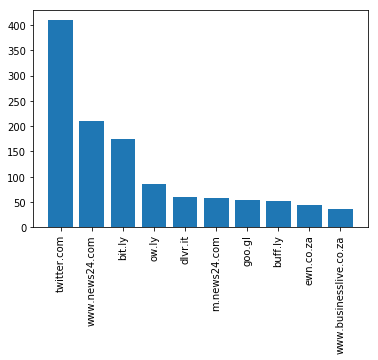

In [26]:
import re
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


domains = defaultdict(int)
sorted_domains = list()
sorted_counts = list()

# keep track of whether each domain was linked using HTTPS
https = {}

for d in data:
    url = str(d["urls_expanded_url"][0])
    dom = re.match(r'(http.*)\/\/(.*?)\/', url)
    if dom:
        domain = dom.group(2)
        domains[domain] += 1
        https[domain] = (dom.group(1) == 'https:')
        
sdomains = sorted(domains, key=domains.get, reverse=True)

for w in sdomains:
    sorted_domains.append(w)
    sorted_counts.append(domains[w])
    # this will print all of the domains and their counts.
    # the tail may be the most interesting part
    # print w, domains[w]

# plot the most popular domains that show up in URLs
# plot shows only the top 10. domains has all of the counts

x = sorted_domains[:10]
y = sorted_counts[:10]

plt.bar(x,y)
plt.xticks(x, rotation='vertical')
plt.show()

## Explore Characteristics of Each Domain Name

First we'll extract the following characteristics of the domain names in each Tweet:
(1) The IP addresses that each domain resolves to
(2) The DNS nameservers that each domain is authoritative for

In [6]:
host_countries = dict()
ips = dict()
nameservers = dict()
ns_ips = dict()

### A Record Lookup

In [7]:
# requires: dnspython library

import dns.resolver

# Lookup IP addresses / A Records of Domain Names
for qname in sdomains:
    ips[qname] = list()
    
    try:
        answers = dns.resolver.query(qname, 'A')
    except dns.resolver.NXDOMAIN as e:
        # the domain does not exist so dns resolutions remain empty
        pass
    except dns.resolver.NoAnswer as e:
        # the resolver is not answering so dns resolutions remain empty
        pass

    for rdata in answers:
        #print qname, domains[qname], rdata.address
        ips[qname].append(rdata.address)
        
print ips['twitter.com'][0]

104.244.42.65


In [8]:
# dictionary of all of the DNS domain names -> IP addresses that host the websites
print ips

{'www.wayamo.com': [u'129.121.176.228'], 'www.loyolaandnews.es': [u'91.192.110.199'], 'simplecast.com': [u'54.87.115.109', u'35.173.151.154', u'52.200.78.105', u'18.232.28.162', u'34.193.215.247', u'52.72.25.31'], 'nnd.ng': [u'54.213.66.64'], 'www.dispatchlive.co.za': [u'216.58.223.83'], 'www.thepresidency.gov.za': [u'41.0.5.139'], 'www.sabreakingnews.co.za': [u'104.199.94.19'], 'southerncourier.co.za': [u'104.24.11.33', u'104.24.10.33'], 'actionkingbest.blogspot.com': [u'216.58.223.65'], 'ift.tt': [u'67.199.248.12', u'67.199.248.13'], 'readinglist.click': [u'34.251.166.161'], 'theconversation.com': [u'151.101.2.110', u'151.101.66.110', u'151.101.130.110', u'151.101.194.110'], 'trib.al': [u'54.84.189.246', u'18.232.216.80', u'54.174.224.48'], 'blogs.worldbank.org': [u'104.17.187.11', u'104.17.188.11'], 'www.scmp.com': [u'103.206.40.111', u'47.89.56.101'], 'www.regularnews.net': [u'160.153.16.34'], 'www.flickr.com': [u'77.238.180.12', u'87.248.114.11', u'77.238.180.11', u'87.248.114.12'

### NS Record Lookup

In [9]:
# Lookup NS Records for Each Domain Name

for qname in sdomains:
    nameservers[qname] = list()
    
    try:
        answer = dns.resolver.query(qname, 'NS', raise_on_no_answer=False)
    except dns.resolver.NXDOMAIN as e:
        # the domain does not exist so dns resolutions remain empty
        pass
    except dns.resolver.NoAnswer as e:
        # the resolver is not answering so dns resolutions remain empty
        pass
    
    if answer.rrset is not None:        
        for ns in answer.rrset.items:
              fqdn = ns.to_text().upper()
              nameservers[qname].append(fqdn)

In [10]:
# dictionary of all of the DNS domain names -> DNS Namservers
print nameservers

{'www.wayamo.com': ['NS1.ASMALLORANGE.COM.', 'NS2.ASMALLORANGE.COM.'], 'www.loyolaandnews.es': ['DNS1.HISPALISDNS.COM.', 'DNS3.HISPALISDNS.COM.', 'DNS2.HISPALISDNS.COM.'], 'simplecast.com': ['NS-435.AWSDNS-54.COM.', 'NS-1649.AWSDNS-14.CO.UK.', 'NS-1055.AWSDNS-03.ORG.', 'NS-714.AWSDNS-25.NET.'], 'nnd.ng': ['AMIT.NS.CLOUDFLARE.COM.', 'ASA.NS.CLOUDFLARE.COM.'], 'www.dispatchlive.co.za': [], 'www.thepresidency.gov.za': [], 'www.sabreakingnews.co.za': [], 'southerncourier.co.za': ['LISA.NS.CLOUDFLARE.COM.', 'THOMAS.NS.CLOUDFLARE.COM.'], 'actionkingbest.blogspot.com': [], 'ift.tt': ['NS-1876.AWSDNS-42.CO.UK.', 'NS-1195.AWSDNS-21.ORG.', 'NS-60.AWSDNS-07.COM.', 'NS-901.AWSDNS-48.NET.'], 'readinglist.click': ['NS06.DOMAINCONTROL.COM.', 'NS05.DOMAINCONTROL.COM.'], 'theconversation.com': ['NS5.DNSUNLIMITED.COM.', 'NS1.DNSUNLIMITED.COM.', 'NS1.DNSIMPLE.COM.', 'NS4.DNSIMPLE.COM.', 'NS2.DNSIMPLE.COM.', 'NS3.DNSIMPLE.COM.'], 'trib.al': ['NS-1190.AWSDNS-20.ORG.', 'NS-637.AWSDNS-15.NET.', 'NS-1885.AWSD

### Map Each IP Address to its corresponding ISP (AS Number) and Country

In [11]:
import pyasn

asndb = pyasn.pyasn('/Users/feamster/anaconda2/ipasn.dat')
asndb.lookup('8.8.8.8')

(15169, '8.8.8.0/24')

In [12]:
from geoip import geolite2

match = geolite2.lookup('17.0.0.1')
print match.country

US


In [30]:
for qname in ips.keys():
    host_countries[qname] = list()
    for i in range(len(ips[qname])):
        ip_match = geolite2.lookup(ips[qname][i])
        if ip_match is None:
            continue
            
        host_countries[qname].append(ip_match.country)
        print qname, domains[qname], asndb.lookup(ips[qname][i]), ip_match.country


www.wayamo.com 1 (36444, '129.121.176.0/20') US
www.loyolaandnews.es 1 (39020, '91.192.110.0/24') ES
simplecast.com 1 (14618, '54.87.0.0/16') US
simplecast.com 1 (14618, '35.168.0.0/13') US
simplecast.com 1 (14618, '52.200.0.0/13') US
simplecast.com 1 (14618, '18.232.0.0/14') US
simplecast.com 1 (14618, '34.192.0.0/12') US
simplecast.com 1 (14618, '52.72.0.0/15') US
nnd.ng 3 (16509, '54.213.0.0/16') US
www.dispatchlive.co.za 1 (15169, '216.58.223.0/24') US
www.thepresidency.gov.za 7 (36994, '41.0.5.0/24') ZA
www.sabreakingnews.co.za 1 (15169, '104.199.64.0/19') US
southerncourier.co.za 2 (13335, '104.24.0.0/20') US
southerncourier.co.za 2 (13335, '104.24.0.0/20') US
actionkingbest.blogspot.com 1 (15169, '216.58.223.0/24') US
ift.tt 26 (395224, '67.199.248.0/24') US
ift.tt 26 (395224, '67.199.248.0/24') US
readinglist.click 4 (16509, '34.248.0.0/13') US
theconversation.com 9 (54113, '151.101.0.0/22') US
theconversation.com 9 (54113, '151.101.64.0/22') US
theconversation.com 9 (54113, '1

www.utrikesmagasinet.se 1 (35706, '91.212.209.0/24') SE
www.fin24.com 33 (10474, '41.86.96.0/19') ZA
www.702.co.za 12 (36937, '41.160.0.0/12') ZA
mype.co.za 2 (22878, '162.247.76.0/22') US
www.independent.co.uk 3 (54113, '151.101.172.0/22') US
africannewsagency.com 3 (16509, '52.208.0.0/13') US
africannewsagency.com 3 (16509, '34.240.0.0/13') US
sa-news.com 7 (49282, '95.175.96.0/19') FI
blog.outtakeonline.com 1 (15169, '216.58.223.0/24') US
select.timeslive.co.za 1 (15169, '216.239.36.0/24') US
select.timeslive.co.za 1 (15169, '216.239.32.0/24') US
select.timeslive.co.za 1 (15169, '216.239.38.0/24') US
select.timeslive.co.za 1 (15169, '216.239.34.0/24') US
profmoosa.wordpress.com 1 (2635, '192.0.78.0/24') US
profmoosa.wordpress.com 1 (2635, '192.0.78.0/24') US


### Map Each DNS Nameserver to Its Corresponding IP Address and Country

In [17]:
for qname in nameservers.keys():
    
    ns_ips[qname] = list()
    
    for i in range(len(nameservers[qname])):
        nsname = nameservers[qname][i]
        try:
            answers = dns.resolver.query(nsname, 'A')
        except dns.resolver.NXDOMAIN as e:
            # the domain does not exist so dns resolutions remain empty
            pass
        except dns.resolver.NoAnswer as e:
            # the resolver is not answering so dns resolutions remain empty
            pass

        for rdata in answers:
            ns_ips[qname].append(rdata.address)

In [19]:
for qname in ns_ips.keys():
    for i in range(len(ips[qname])):
        ip_match = geolite2.lookup(ips[qname][i])
        if ip_match is None:
            continue
            
        ip_country = ip_match.country
        print qname, domains[qname], asndb.lookup(ips[qname][i]), ip_country

www.wayamo.com 1 (36444, '129.121.176.0/20') US
za.trendwiki.co 5 (63949, '178.79.128.0/18') GB
simplecast.com 1 (14618, '54.87.0.0/16') US
simplecast.com 1 (14618, '35.168.0.0/13') US
simplecast.com 1 (14618, '52.200.0.0/13') US
simplecast.com 1 (14618, '18.232.0.0/14') US
simplecast.com 1 (14618, '34.192.0.0/12') US
simplecast.com 1 (14618, '52.72.0.0/15') US
nnd.ng 3 (16509, '54.213.0.0/16') US
www.dispatchlive.co.za 1 (15169, '216.58.223.0/24') US
www.thepresidency.gov.za 7 (36994, '41.0.5.0/24') ZA
www.sabreakingnews.co.za 1 (15169, '104.199.64.0/19') US
southerncourier.co.za 2 (13335, '104.24.0.0/20') US
southerncourier.co.za 2 (13335, '104.24.0.0/20') US
actionkingbest.blogspot.com 1 (15169, '216.58.223.0/24') US
ift.tt 26 (395224, '67.199.248.0/24') US
ift.tt 26 (395224, '67.199.248.0/24') US
readinglist.click 4 (16509, '34.248.0.0/13') US
theconversation.com 9 (54113, '151.101.0.0/22') US
theconversation.com 9 (54113, '151.101.64.0/22') US
theconversation.com 9 (54113, '151.10

profmoosa.wordpress.com 1 (2635, '192.0.78.0/24') US
profmoosa.wordpress.com 1 (2635, '192.0.78.0/24') US


### Get Some Fake News Labels

I used the kaggle dataset, which you can obtain from here:
https://github.com/bradmiro/fake_news_detector

and quickly post-processed it with perl to get some domains:

cut -f 10 -d ',' formatted_kaggle_training_data.csv | perl -e 'while (<>) {if ($_ =~ /^[a-z]*\.(net|com|org)$/) {print "$_"}}' | uniq''

In [60]:
fake = defaultdict(int)

with open('/Users/feamster/fake-news-urls.txt') as f:
    for l in f.readlines():
        fake[l.strip()] = 1

In [64]:
print "cnn: " , fake['cnn.com']
print "zerohedge: ", fake['zerohedge.com']


cnn:  0
zerohedge:  1


### Build a Feature Table

In [65]:
for q in domains.keys():
    if len(host_countries[q]) < 1:
        continue
    print q, domains[q], len(set(ips[q])), len(set(host_countries[q])), host_countries[q][0], https[q], fake[q]

www.wayamo.com 1 1 1 US False 0
www.loyolaandnews.es 1 1 1 ES False 0
simplecast.com 1 6 1 US True 0
nnd.ng 3 1 1 US False 0
www.dispatchlive.co.za 1 1 1 US True 0
www.thepresidency.gov.za 7 1 1 ZA False 0
www.sabreakingnews.co.za 1 1 1 US False 0
southerncourier.co.za 2 2 1 US True 0
actionkingbest.blogspot.com 1 1 1 US False 0
ift.tt 26 2 1 US True 0
readinglist.click 4 1 1 US True 0
theconversation.com 9 4 1 US True 0
trib.al 1 3 1 US True 0
blogs.worldbank.org 1 2 1 US False 0
www.scmp.com 1 2 1 CA False 0
www.regularnews.net 1 1 1 US False 0
www.flickr.com 5 4 1 GB True 0
yesafrika.wordpress.com 1 2 1 US True 0
agendamagasin.no 1 1 1 NO True 0
www.alaraby.co.uk 1 1 1 US True 0
africareportonbusiness.com 4 1 1 US True 0
ghtube.com 2 1 1 US False 0
m.health24.com 1 1 1 ZA True 0
www.pscp.tv 6 2 1 US True 0
townpress.co.za 11 1 1 ZA False 0
www.causes.com 2 2 1 US True 0
www.msn.com 8 1 1 US False 0
www.farmersweekly.co.za 2 1 1 ZA True 0
www.politicsweb.co.za 5 1 1 ZA False 0
allafr